In [225]:
#%pip install -U albumentations
#%pip install efficientnet_pytorch

Detection commets coma 

In [214]:
import os
from os import listdir
from os.path import isfile, join
import shutil
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io.image import read_image
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import cv2

# Utility functions

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

def print_image(sample):
    # for example:  print_image(train[2])
    fig, ax = plt.subplots(figsize = (9,9))
    
    image = np.moveaxis(sample['image'].numpy(), 0, 2)
    ax.imshow(image)
    
    print(sample['file_name'])
    
    x1_y1 = sample['x1_y1'].numpy()
    x2_y2 = sample['x2_y2'].numpy()
    
    w = abs(x1_y1[0] - x2_y2[0]) * image.shape[0]
    h = abs(x1_y1[1] - x2_y2[1]) * image.shape[1]
    x = min(x1_y1[0],x2_y2[0]) * image.shape[0]
    y = min(x1_y1[1],x2_y2[1]) * image.shape[1]
    
    ax.add_patch(patches.Rectangle((x,y),w,h,
                                   fill=False, edgecolor='red', lw=2))
    plt.show()

def show_images_batch(batch):
    img_list = batch['image']
    x1_y1_list = batch['x1_y1']
    x2_y2_list = batch['x2_y2']
    ratio = batch['ratio']
    
    label = batch['label']
    files_name = batch['file_name']

    show_list_images(img_list, x1_y1_list, x2_y2_list, ratio, files_name)

def show_list_images(img_list, x1_y1_list, x2_y2_list, ratio, files_name):
    
    fig = plt.figure(figsize = (20,20))
    for i in range(len(img_list)):
        ax = fig.add_subplot(4, 4, i+1)
        image = np.moveaxis(img_list[i].cpu().detach().numpy(), 0, 2)
        ax.imshow(image)
        x1_y1 = x1_y1_list[i].cpu().detach().numpy()
        x2_y2 = x2_y2_list[i].cpu().detach().numpy()

        w = abs(x1_y1[0] - x2_y2[0]) * image.shape[0]
        h = abs(x1_y1[1] - x2_y2[1]) * image.shape[1]
        x = min(x1_y1[0],x2_y2[0]) * image.shape[0]
        y = min(x1_y1[1],x2_y2[1]) * image.shape[1]
        
        ax.add_patch(patches.Rectangle((x,y),w,h,
                     fill=False, edgecolor='red', lw=2))
        file_path, file_name = os.path.split(files_name[i])
        ax.set_title('File {0} ratio {1:.5f}'.format(file_name,ratio[i].numpy()))

    plt.show()
    
def get_commet_detection(path_to_image, path_to_model):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import patches
    import torch
    from torchvision.transforms import ToTensor
    from PIL import Image
    
    pil_img = Image.open(path_to_image).convert('RGB')
    img_resize = pil_img.resize((500,500))
    #np_arr = np.moveaxis(np.asarray(pil_img),0, 2)
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(img_resize)

    image = ToTensor()(np.array(img_resize))
    image = image.unsqueeze(0)

    model = torch.load(path_to_model).to(device='cpu')
    model.eval()

    predictions = net.to(device='cpu')(image)
    
    with torch.no_grad():
        x1_y1 = predictions[:, :2]
        x2_y2 = predictions[:, 2:4]
        
        w = abs(x1_y1[0][0] - x2_y2[0][0]) * image.shape[0]
        h = abs(x1_y1[0][1] - x2_y2[0][1]) * image.shape[1]
        x = min(x1_y1[0][0],x2_y2[0][0]) * image.shape[0]
        y = min(x1_y1[0][1],x2_y2[0][1]) * image.shape[1]
    
    ax.add_patch(patches.Rectangle((x,y),w,h,
                                   fill=False, edgecolor='red', lw=2))
           
    plt.show()  

# 1 Dataset и Dataloader

In [216]:
class СometDetectionDataset(Dataset):
    
    def __init__(self, xml_file, img_dir,
                 shuffle=False, train=None,
                 test_size=0.05, transform=None, augmentation_transform=None):
        self.img_dir = img_dir 
        self.transform = transform
        self.augmentation_transform = augmentation_transform
        self.data = self._get_dataset_from_xml_cvat_file(xml_file,shuffle,train,test_size)    
    
    def _get_ratio_means_image_bbox(self, image, x1, y1, x2, y2):

        x_min = min(int(x1),int(x2))
        y_min = min(int(y1),int(y2))
        x_max = max(int(x1),int(x2))
        y_max = max(int(y1),int(y2))
        # get bounding box by coordinates
        bounding_box = image[:,y_min:y_max,x_min:x_max]
        # calc ratio
        mean_all_image = image.mean()
        mean_bounding_box = bounding_box.mean()
        return mean_bounding_box / (mean_all_image + mean_bounding_box)  

    def _get_dataset_from_xml_cvat_file(self,xml_file, shuffle, train, test_size):
        import xml.etree.ElementTree as ET
        import pandas as pd
        from sklearn.model_selection import train_test_split

        df = pd.DataFrame(columns=['file_name','x1','y1','x2','y2','label'])
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for file_item in root.iter(tag='image'):

            name_file = file_item.attrib['name']
            box_info = file_item.findall('box')
            if len(box_info)==0:
                continue
            else:
                box_info = box_info[0]
                x1 = float(box_info.get('xtl'))
                y1 = float(box_info.get('ytl'))
                x2 = float(box_info.get('xbr'))
                y2 = float(box_info.get('ybr'))
                df.loc[len(df),:] = [os.path.join(self.img_dir,name_file), x1, y1, x2, y2, 1]
        # return all dataset
        if train==None:
            return df
        # split dataset to train and test
        train_df, test_df = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=42)
        if train==True:
            if not self.augmentation_transform==None:
                # create dir for augment images
                path_to_save_aug = os.path.join(self.img_dir + 'aug/')
                if not os.path.exists(path_to_save_aug):
                    os.mkdir(path_to_save_aug)
                else:
                    # clear previous images 
                    shutil.rmtree(path_to_save_aug)
                    os.mkdir(path_to_save_aug)
                    
                df_aug = pd.DataFrame(columns=['file_name','x1','y1','x2','y2','label'])
                for index, row in train_df.iterrows():
                    for j in range(len(self.augmentation_transform)):
                        image = cv2.imread(row.file_name)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        bboxes = [[row.x1, row.y1, row.x2, row.y2,1]]
                        transformed = self.augmentation_transform[j](image=image, bboxes=bboxes)
                        transformed_image = transformed['image']

                        transformed_bboxes = transformed['bboxes']
                        (file_name, ext) = os.path.splitext(row.file_name)
                        new_file_name = file_name.split('/')[-1] + f'_aug{j+1}' + ext
                        new_file_name = new_file_name
                        new_file_name = os.path.join(path_to_save_aug, new_file_name)
                        cv2.imwrite(new_file_name, transformed_image)
                        df_aug.loc[len(df_aug),:] = [new_file_name,
                                                         transformed_bboxes[0][0],transformed_bboxes[0][1],
                                                         transformed_bboxes[0][2],transformed_bboxes[0][3],
                                                         transformed_bboxes[0][4]]
                if len(df_aug) > 0:
                    train_df = pd.concat([train_df,df_aug])
            return train_df.reset_index()
        else:
            return test_df.reset_index()
        return df
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        result = {}
        # get path to image
        row = self.data.loc[idx]
        #img_path = os.path.join(self.img_dir, row.file_name)
        img_path = row.file_name
        if os.path.exists(img_path):
            # label studio change space to _ 
            image = read_image(img_path)
            # if need do transform data
            if self.transform:
                image = self.transform(image)
            # normalize image
            min_max_norm = (image - image.min())/(image.max() - image.min())
            result['image'] = min_max_norm
            # coordinates of bounding box have been converted to percent of image size
            result['x1_y1'] = torch.FloatTensor([row.x1/image.shape[1],row.y1/image.shape[2]])
            result['x2_y2'] = torch.FloatTensor([row.x2/image.shape[1],row.y2/image.shape[2]])
            # add human experience: mean signal in bounding box must much differ at mean signal all image
            result['ratio'] = self._get_ratio_means_image_bbox(min_max_norm,row.x1,row.y1,row.x2,row.y2)
            result['label'] = torch.LongTensor(row.label)
        else:
            result['image'] = None
            result['x1_y1'] = None
            result['x2_y2'] = None
            result['label'] = None
        # utility feacher for printing images 
        result['file_name'] = row.file_name
        return result

In [217]:
aug_transform_1 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.HorizontalFlip(p=0.5),
                           A.RandomBrightnessContrast(p=0.2),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))

aug_transform_2 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.VerticalFlip(p=0.5),
                           A.RandomBrightnessContrast(p=0.5),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))

aug_transform_3 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.VerticalFlip(p=0.5), A.HorizontalFlip(p=0.5),
                           A.RandomBrightnessContrast(p=0.7),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))

                      


train = СometDetectionDataset(xml_file='annotations2.xml', img_dir='./resize_images/',
                              train=True, augmentation_transform = [aug_transform_1,aug_transform_2,aug_transform_3])
test = СometDetectionDataset(xml_file = 'annotations2.xml', img_dir='./resize_images/', train=False)
print(f'Train size {len(train)}, test size {len(test)}')

Train size 380, test size 5


In [218]:
train_loader = DataLoader(train, batch_size=8, drop_last=True )
test_loader = DataLoader(test, batch_size=2, drop_last=True)

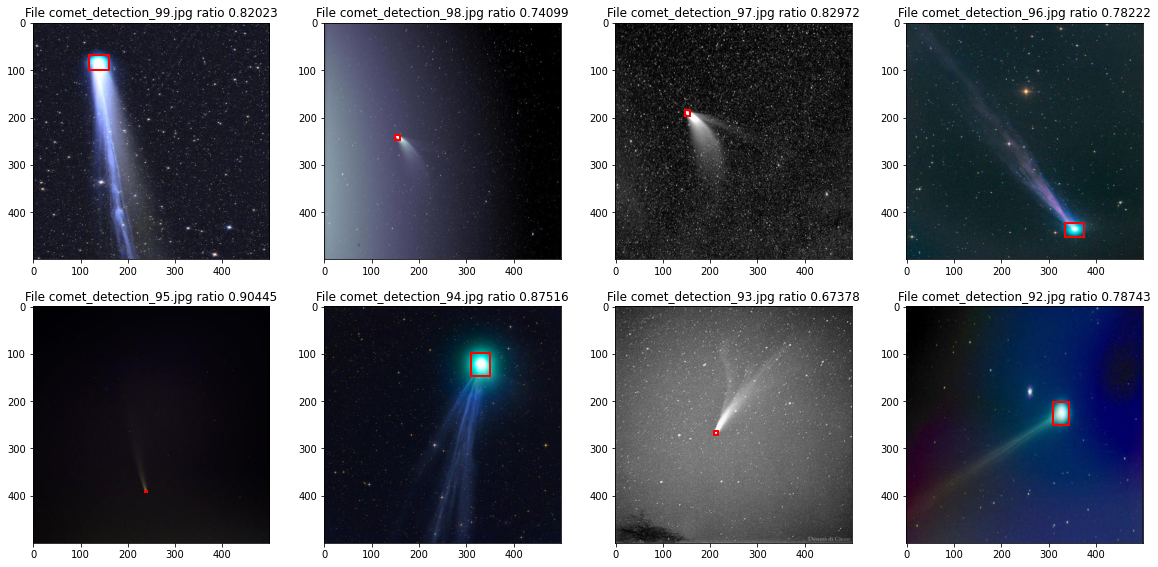

In [219]:
# check if all images and bounding in place
show_images_batch(next(iter(train_loader)))

# 2. Train model

In [220]:
def train_model(net, model_name):
    # import warnings filter
    from warnings import simplefilter
    # ignore all future warnings
    simplefilter(action='ignore', category=FutureWarning)

    loss_MSE = torch.nn.MSELoss()
    loss_MAE = torch.nn.L1Loss()
    #loss_function_bce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    net = net.to(device)

    n_epoch = 500
    for epoch in tqdm(range(n_epoch),total=n_epoch):
        net.train()
        epoch_loss = 0.

        for batch in train_loader:
            images = batch['image']
            x1_y1 = batch['x1_y1']
            x2_y2 = batch['x2_y2']
            ratio = batch['ratio']
            images = images.to(device,dtype=torch.float)
            x1_y1 = x1_y1.to(device)
            x2_y2 = x2_y2.to(device)
            ratio = torch.unsqueeze(ratio, 1)
            ratio = ratio.to(device)

            optimizer.zero_grad()
            predictions = net(images)

            loss = (loss_MAE(predictions[:, :2], x1_y1) + \
                loss_MAE(predictions[:, 2:4], x2_y2) + \
                loss_MSE(predictions[:, 4:5], ratio))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        clear_output(wait=True)
        epoch_loss = epoch_loss / len(train_loader)
        print(f'Train: loss = {epoch_loss}')
        df.loc[len(df),:] = [model_name,epoch,epoch_loss]

    torch.save(net, f'comet_detection_{model_name}')

    net.eval()
    epoch_loss = 0.
    for batch in test_loader:
        # batch data to cuda
        images = batch['image']
        x1_y1 = batch['x1_y1']
        x2_y2 = batch['x2_y2']
        ratio = batch['ratio']
        files_name = batch['file_name']
        
        images = images.to(device,dtype=torch.float)
        x1_y1 = x1_y1.to(device)
        x2_y2 = x2_y2.to(device)
        ratio = torch.unsqueeze(ratio, 1)
        ratio = ratio.to(device)

        
        predictions = net(images)
        
        x1_y1_pred = predictions[:, :2]
        x2_y2_pred = predictions[:, 2:4]
        ratio_pred =  predictions[:, 4:5]
        # calc loss
        with torch.no_grad():
            loss = (loss_MAE(x1_y1_pred, x1_y1) + \
                loss_MAE(x2_y2_pred, x2_y2) + \
                loss_MSE(ratio_pred, ratio))
                
        epoch_loss += loss.item()
        # show detect bounding box
        show_list_images(batch['image'], x1_y1_pred, x2_y2_pred, ratio, files_name)

    print(f'Test: loss function {epoch_loss / len(test_loader)}')

In [221]:
df = pd.DataFrame(columns=['model','n_epoch','loss'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2.1 Resnet18

In [226]:
%%time
from torchvision.models import resnet18
net = resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=5, bias=True)

train_model(net, 'resnet_18')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\demko_r/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:04<00:00, 4.93MB/s]
  0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 4.00 GiB total capacity; 2.51 GiB already allocated; 4.23 MiB free; 2.66 GiB reserved in total by PyTorch)

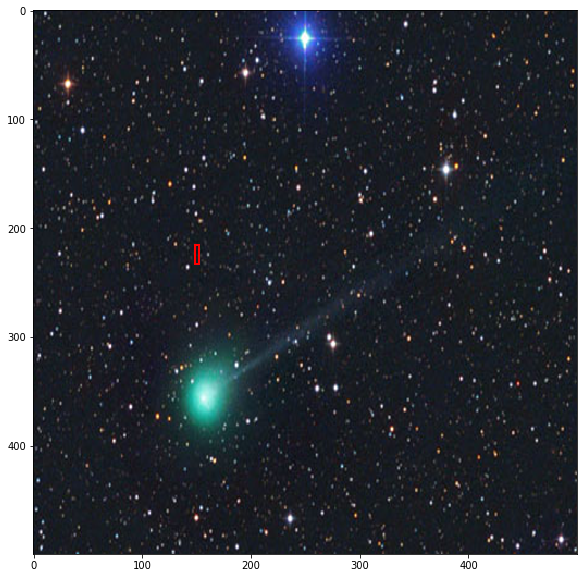

In [11]:
get_commet_detection('./S3-Panstarrs-July-15-Michael-Jaeger-STv1.jpg', './comet_detection_resnet_18')

## 2.2 Efficient net

In [13]:
%%time


from efficientnet_pytorch import EfficientNet
net = EfficientNet.from_pretrained('efficientnet-b0')
net._fc = torch.nn.Linear(in_features=1280, out_features=4, bias=True)

train_model(net, 'efficient_net')


  3%|▎         | 17/500 [03:51<1:49:51, 13.65s/it]Train: loss = 155.67053009836297


KeyboardInterrupt: 

In [ ]:
get_commet_detection('./S3-Panstarrs-July-15-Michael-Jaeger-STv1.jpg', './comet_detection_efficient_net')

## Resnet VS efficient_net

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(training, title):
    fig, ax = plt.subplots(figsize = (10,10))
    ax.plot(training['n_epoch'],training['loss'])
    ax.grid()
    ax.set_title(title)
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    plt.show()
df.to_csv('loss_history.csv',index=False)

In [ ]:
plot_training_curves(df[df.model=='resnet_18'])

In [ ]:
plot_training_curves(df[df.model=='efficient_net'])